
#**Big Data Analytics Project Report: Twitter Analytics**


**Group Members: CED15I007, CED15I026, CED15I029 **

---


#1. Data Preprocessing: Introduction

Our dataset of interest is the 1.6 million tweet dataset that can be found [here](https://http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip), and metadata on this dataset can be found [here](http://help.sentiment140.com/for-students/). 

The dataset is annotated Tweets from "Sentiment140". It originated from a Stanford research project, and is a great resource as well as a good testing ground for Data Analytics.

>By looking at the description of the dataset from the link, the information on each field can be found.

>0 — the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

>1 — the id of the tweet (2087)

>2 — the date of the tweet (Sat May 16 23:58:44 UTC 2009)

>3 — the query (lyx). If there is no query, then this value is NO_QUERY.

>4 — the user that tweeted (robotickilldozr)

>5 — the text of the tweet (Lyx is cool)

The dataset has no NULL entries, yet needs some cleaning which will be highlighted later. This code does the cleaning of the dataset, shows some descriptive statistics to understand and visualize the data better, and exports the cleaned data to be used in the other parts of this project.

The descriptive data is a beautiful word cloud of positive and negative sentimental text and tweets.

In [0]:
import pandas as pd  
import numpy as np

import matplotlib.pyplot as plt
cols = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv("training.1600000.processed.noemoticon.csv",
                 header=None, names=cols, encoding='latin-1')
df = df.sample(400000, random_state=0)
df.head()

,sentiment,id,date,query_string,user,text
557138,0,2204444171,Wed Jun 17 02:14:00 PDT 2009,NO_QUERY,einmensch,wants to compete! i want hard competition! i w...
349381,0,2017152437,Wed Jun 03 07:56:34 PDT 2009,NO_QUERY,keithmorrison,It seems we are stuck on the ground in Amarill...
182051,0,1967043408,Fri May 29 18:52:13 PDT 2009,NO_QUERY,PunkieDory,where the f are my pinking shears? rarararrrar...
571236,0,2208721054,Wed Jun 17 09:32:48 PDT 2009,NO_QUERY,DYkEY_tYPE,0ff t0 tHE MEEtiN.. i HAtE WhEN PPl V0lUNtEER...
1339637,4,2018731586,Wed Jun 03 10:25:27 PDT 2009,NO_QUERY,BlueSmartiies,@ reply me pls


This shows a sample of the data we are working with in its raw form

In [0]:
df = df.reset_index(drop=True)
df.head()

,sentiment,id,date,query_string,user,text
0,0,2204444171,Wed Jun 17 02:14:00 PDT 2009,NO_QUERY,einmensch,wants to compete! i want hard competition! i w...
1,0,2017152437,Wed Jun 03 07:56:34 PDT 2009,NO_QUERY,keithmorrison,It seems we are stuck on the ground in Amarill...
2,0,1967043408,Fri May 29 18:52:13 PDT 2009,NO_QUERY,PunkieDory,where the f are my pinking shears? rarararrrar...
3,0,2208721054,Wed Jun 17 09:32:48 PDT 2009,NO_QUERY,DYkEY_tYPE,0ff t0 tHE MEEtiN.. i HAtE WhEN PPl V0lUNtEER...
4,4,2018731586,Wed Jun 03 10:25:27 PDT 2009,NO_QUERY,BlueSmartiies,@ reply me pls


In [0]:
df.drop(['id','date','query_string','user'],axis=1,inplace=True)

We first started by dropping the columns that are not needed for the specific purpose of sentiment analysis.

>“id” column is unique ID for each tweet

>“date” column is for date info for the tweet

>“query_string” column indicates whether the tweet has been collected with any particular query key word, but for this column, 100% of the entries are with value “NO_QUERY”

>“user” column is the twitter handle name for the user who tweeted

Hence, we decided to drop above four columns as they are unused for our project and would casue excessive unrequired overhead.

In [0]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

##Data Cleaning

###Step 1 : HTML Encoding
--

In the tweet data, HTML encoding has not been converted to text, and ended up in text field as ‘&amp’,’&quot’,etc. Decoding HTML to general text will be the first step of data cleaning. Wel used the BeautifulSoup package in python for this task.

###Step 2 : Mentions
--

The second part of the preparation is dealing with @mention.
Even though @mention carries a certain information (which another user that the tweet mentioned), this information doesn’t add value to build sentiment analysis model.

###Step 3: URL links
--

The third part of the cleaning is dealing with URL links, same with @mention, even though it carries some information, for sentiment analysis purpose, this can be ignored.

###Step 4: UTF-8 BOM (Byte Order Mark)
--

By looking at the above entry, we saw strange patterns of characters “\xef\xbf\xbd”. After some researching, we realised that these are UTF-8 BOM.
“The UTF-8 BOM is a sequence of bytes (EF BB BF) that allows the reader to identify a file as being encoded in UTF-8.”

By decoding text with ‘utf-8-sig’, this BOM will be replaced with unicode unrecognisable special characters, then they can be processed as “?”

###Step 5: Hashtag / Numbers
--
Sometimes the text used with hashtag can provide useful information about the tweet. It might be a bit risky to get rid of all the text together with the hashtag.
So we decided to leave the text intact and just remove the ‘#’. This will be done in the process of cleaning all the non letter characters including numbers.



In [0]:
print("Cleaning and parsing the tweets...\n")
clean_tweet_texts = []
for i in range(400000):
    clean_tweet_texts.append(cleaner(df['text'][i]))

Cleaning and parsing the tweets...



With above five data cleaning tasks, we first defined a data cleaning function (as seen above), and then applied it to the whole dataset. 

Now we have properly cleaned and Analytically usable data to work with!

In [0]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['target'] = df.sentiment
clean_df.head()

,text,target
0,wants to compete want hard competition want to...,0
1,it seems we are stuck on the ground in amarill...,0
2,where the are my pinking shears rarararrrarara...,0
3,ff the meetin hate when ppl lunteer my free ti...,0
4,reply me pls,4


Then we convert this data into a Pandas dataframe for ease of use further ahead in the project

In [0]:
clean_df.to_csv('clean_tweet.csv')

We then save it in a csv file for safekeeping.

In [0]:
csv = 'clean_tweet.csv'
df = pd.read_csv(csv, index_col=0)
df['text'] = df['text'].astype('str')
df.head()

,text,target
0,wants to compete want hard competition want to...,0
1,it seems we are stuck on the ground in amarill...,0
2,where the are my pinking shears rarararrrarara...,0
3,ff the meetin hate when ppl lunteer my free ti...,0
4,reply me pls,4


Confirmation of working and validity of the stored csv file

In [0]:
df.dtypes

text      object
target     int64
dtype: object

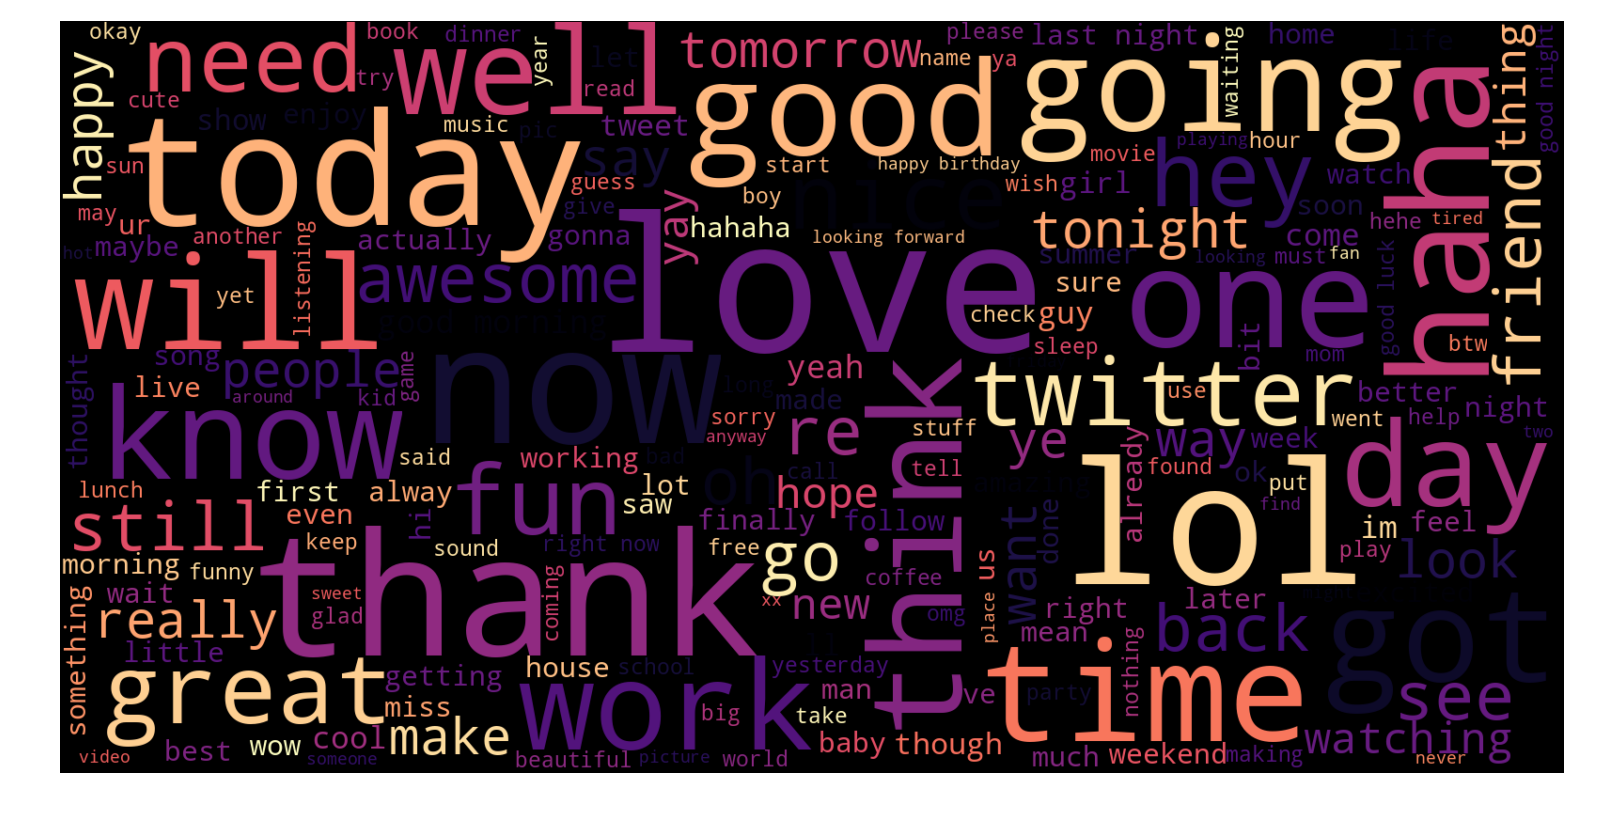

In [0]:
from wordcloud import WordCloud
pos_tweets = df[df.target == 4]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
# print(pos_string)
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

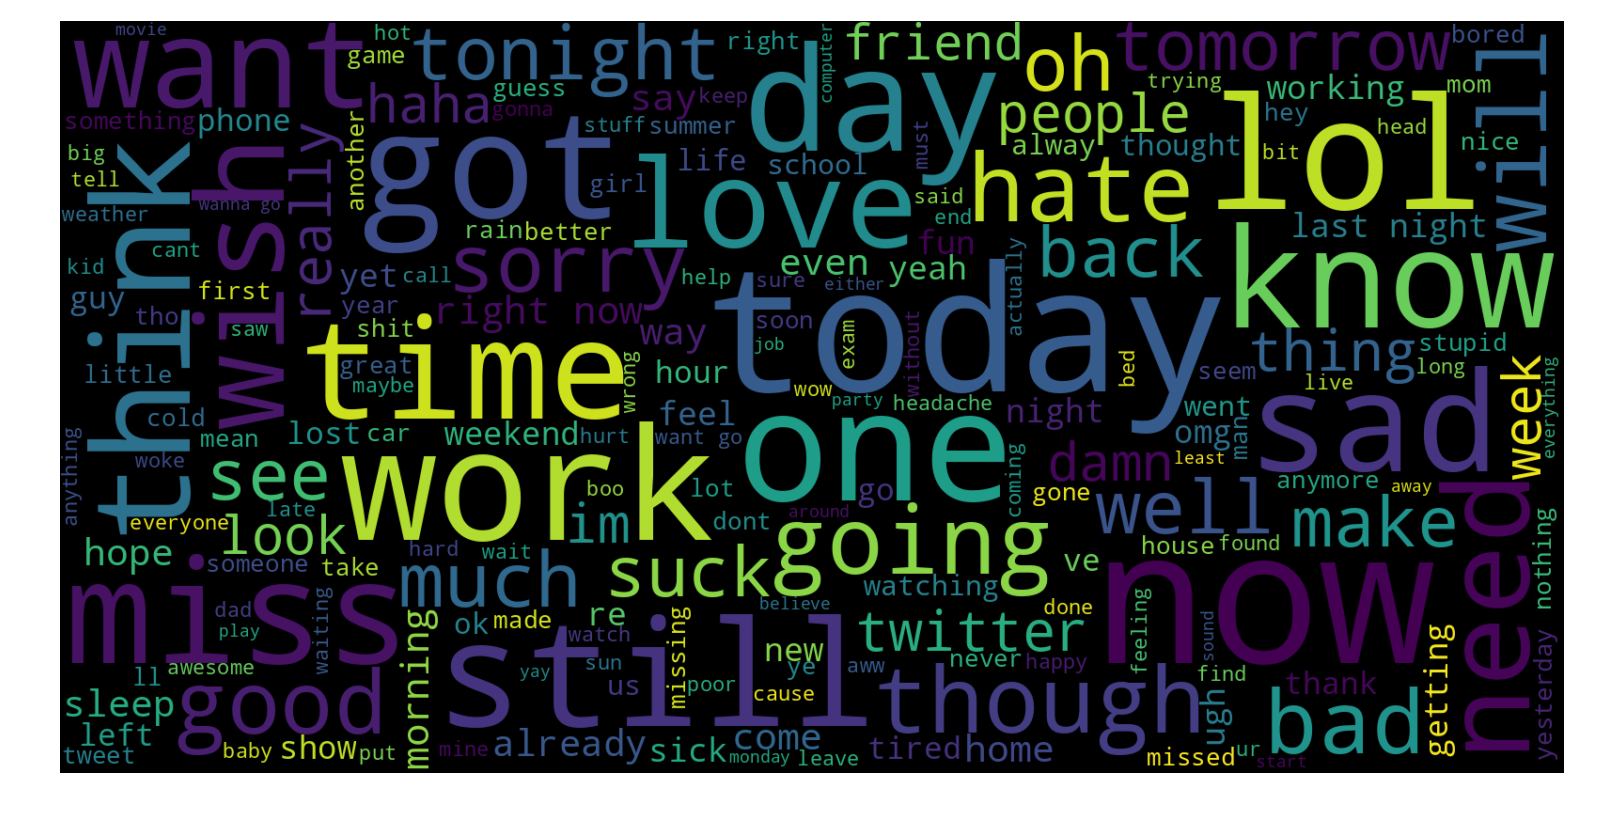

In [0]:
from wordcloud import WordCloud
neg_tweets = df[df.target == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
# print(pos_string)
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

##Result

We now used this cleaned dataset to generate a word cloud to visualize it better. We can see that the first word cloud has all the text from positive tagged tweets in a warm colour map and the second word cloud has text from the negative tagged tweets in a cool colour map.

This shows us how big the set actually is and the magnitude of text we are working with.